In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline


In [4]:
# Load the training dataset
train = pd.read_csv("train.csv", parse_dates=['date'])



In [ ]:
train.shape, train.columns, train.dtypes, train.head(), train.describe(), train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 137.4+ MB


((3000888, 6),
 Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion'], dtype='object'),
 id                      int64
 date           datetime64[ns]
 store_nbr               int64
 family                 object
 sales                 float64
 onpromotion             int64
 dtype: object,
    id       date  store_nbr      family  sales  onpromotion
 0   0 2013-01-01          1  AUTOMOTIVE    0.0            0
 1   1 2013-01-01          1   BABY CARE    0.0            0
 2   2 2013-01-01          1      BEAUTY    0.0            0
 3   3 2013-01-01          1   BEVERAGES    0.0            0
 4   4 2013-01-01          1       BOOKS    0.0            0,
                  id                           date     store_nbr  \
 count  3.000888e+06                        3000888  3.000888e+06   
 mean   1.500444e+06  2015-04-24 08:27:04.703088384  2.750000e+01   
 min    0.000000e+00            2013-01-01 00:00:00  1.000000e+00   
 25%    7.502218e+05            2014-02-26 18:00:00  

In [16]:
# Focus on one time series for prototyping
df = train[(train['store_nbr'] == 1) & (train['family'] == 'BEVERAGES')].copy()

# Set the date as index and sort it
df.set_index('date', inplace=True)
df.sort_index(inplace=True)

# Quick look
df.head()


,id,store_nbr,family,sales,onpromotion
date,,,,,
2013-01-01,3,1,BEVERAGES,0.0,0
2013-01-02,1785,1,BEVERAGES,1091.0,0
2013-01-03,3567,1,BEVERAGES,919.0,0
2013-01-04,5349,1,BEVERAGES,953.0,0
2013-01-05,7131,1,BEVERAGES,1160.0,0


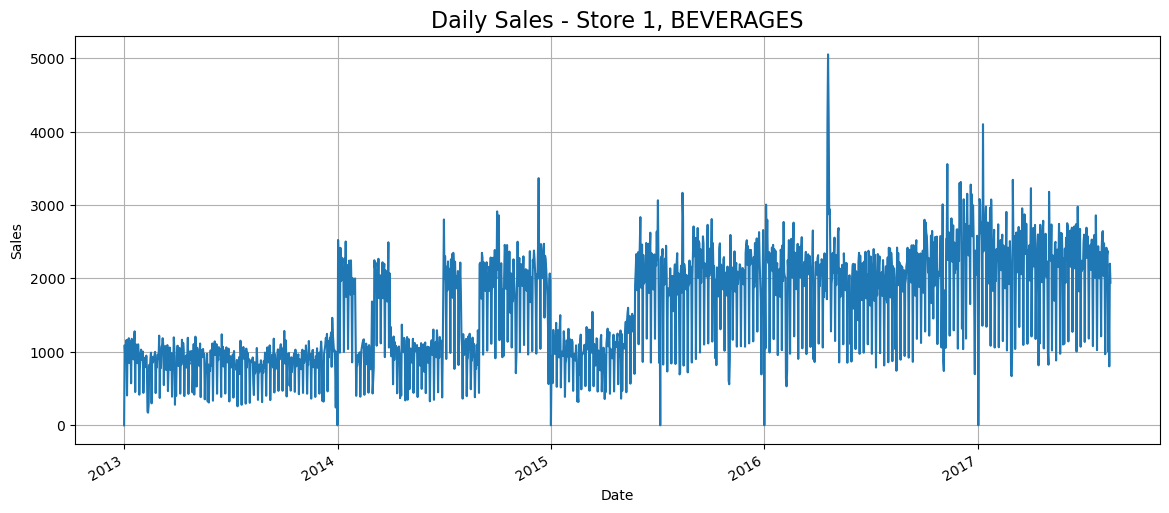

In [18]:
# Plot daily sales
plt.figure(figsize=(14, 6))
df['sales'].plot()
plt.title('Daily Sales - Store 1, BEVERAGES', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid(True)
plt.show()


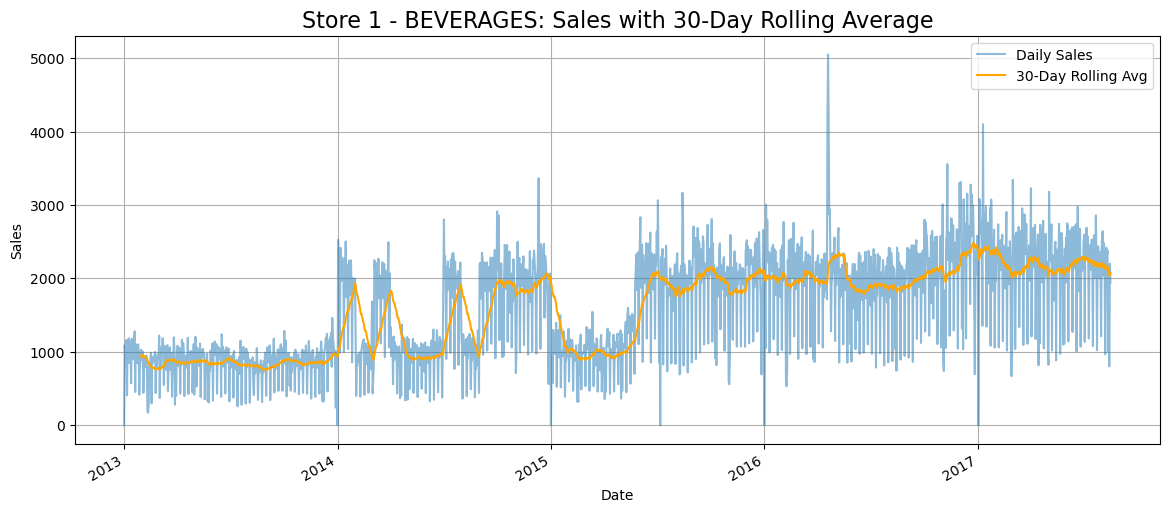

In [20]:
# Plot with 30-day rolling average
plt.figure(figsize=(14, 6))
df['sales'].plot(label='Daily Sales', alpha=0.5)
df['sales'].rolling(window=30).mean().plot(label='30-Day Rolling Avg', color='orange')
plt.title('Store 1 - BEVERAGES: Sales with 30-Day Rolling Average', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()


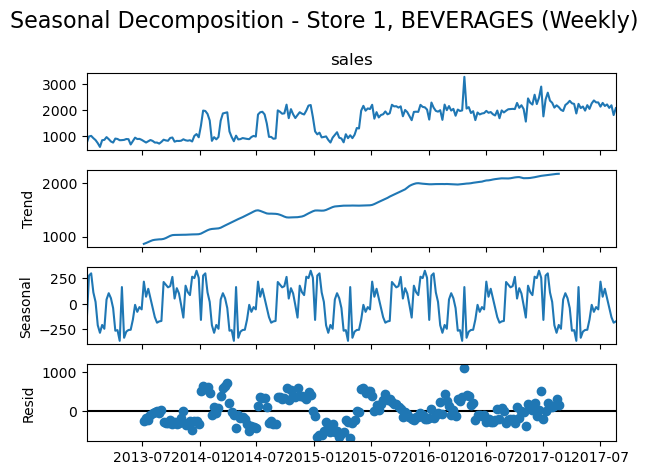

In [21]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Resample to weekly averages
weekly_sales = df['sales'].resample('W').mean()

# Perform additive decomposition with yearly cycle (52 weeks)
decomp = seasonal_decompose(weekly_sales, model='additive', period=52)

# Plot components
decomp.plot()
plt.suptitle('Seasonal Decomposition - Store 1, BEVERAGES (Weekly)', fontsize=16)
plt.tight_layout()
plt.show()


In [22]:
from statsmodels.tsa.stattools import adfuller

# Run ADF test on weekly sales
result = adfuller(weekly_sales.dropna())

# Print test results
print('ADF Statistic:', result[0])
print('p-value:', result[1])
for key, value in result[4].items():
    print(f'Critical Value {key}: {value}')

ADF Statistic: -2.040743823739594
p-value: 0.26899888460850374
Critical Value 1%: -3.4583663275730476
Critical Value 5%: -2.8738660999177132
Critical Value 10%: -2.5733390785693766


In [23]:
# First difference
weekly_diff = weekly_sales.diff().dropna()

# Re-run ADF test
result_diff = adfuller(weekly_diff)

print('ADF Statistic (1st diff):', result_diff[0])
print('p-value:', result_diff[1])
for key, value in result_diff[4].items():
    print(f'Critical Value {key}: {value}')


ADF Statistic (1st diff): -8.784392349566831
p-value: 2.3297986759805955e-14
Critical Value 1%: -3.4586084859607156
Critical Value 5%: -2.873972159235721
Critical Value 10%: -2.57339565928848


In [24]:
from pmdarima import auto_arima

# Fit auto_arima
stepwise_model = auto_arima(
    weekly_sales,
    seasonal=True,
    m=52,  # Weekly data with annual seasonality
    d=1,   # Already determined via ADF
    D=1,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)

# Display best model
print(stepwise_model.summary())


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[52]             : AIC=inf, Time=22.94 sec
 ARIMA(0,1,0)(0,1,0)[52]             : AIC=2753.913, Time=0.61 sec
 ARIMA(1,1,0)(1,1,0)[52]             : AIC=2708.351, Time=3.54 sec
 ARIMA(0,1,1)(0,1,1)[52]             : AIC=inf, Time=7.78 sec
 ARIMA(1,1,0)(0,1,0)[52]             : AIC=2752.252, Time=0.20 sec
 ARIMA(1,1,0)(2,1,0)[52]             : AIC=2699.712, Time=13.16 sec
 ARIMA(1,1,0)(2,1,1)[52]             : AIC=inf, Time=41.88 sec
 ARIMA(1,1,0)(1,1,1)[52]             : AIC=inf, Time=15.12 sec
 ARIMA(0,1,0)(2,1,0)[52]             : AIC=2710.186, Time=10.84 sec
 ARIMA(2,1,0)(2,1,0)[52]             : AIC=2701.634, Time=18.93 sec
 ARIMA(1,1,1)(2,1,0)[52]             : AIC=2701.653, Time=20.54 sec
 ARIMA(0,1,1)(2,1,0)[52]             : AIC=2699.995, Time=17.09 sec
 ARIMA(2,1,1)(2,1,0)[52]             : AIC=inf, Time=21.99 sec
 ARIMA(1,1,0)(2,1,0)[52] intercept   : AIC=2701.703, Time=21.59 sec

Best model:  ARIMA(1,1,0)(2,1,0)[

In [25]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fit SARIMA using the best params from auto_arima
model = SARIMAX(
    weekly_sales,
    order=(1, 1, 0),
    seasonal_order=(2, 1, 0, 52),
    enforce_stationarity=False,
    enforce_invertibility=False
)

results = model.fit()

# Summary
print(results.summary())


                                     SARIMAX Results                                      
Dep. Variable:                              sales   No. Observations:                  242
Model:             SARIMAX(1, 1, 0)x(2, 1, 0, 52)   Log Likelihood                -595.610
Date:                            Fri, 18 Apr 2025   AIC                           1199.221
Time:                                    15:31:52   BIC                           1208.944
Sample:                                01-06-2013   HQIC                          1203.130
                                     - 08-20-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4805      0.075     -6.393      0.000      -0.628      -0.333
ar.S.L52      -0.5651      0.100   

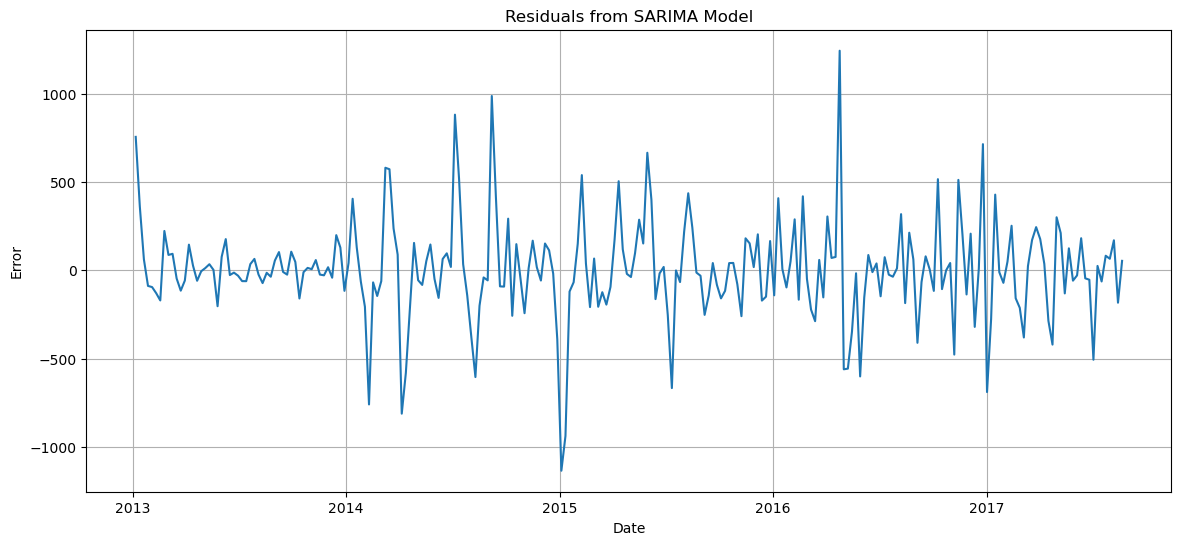

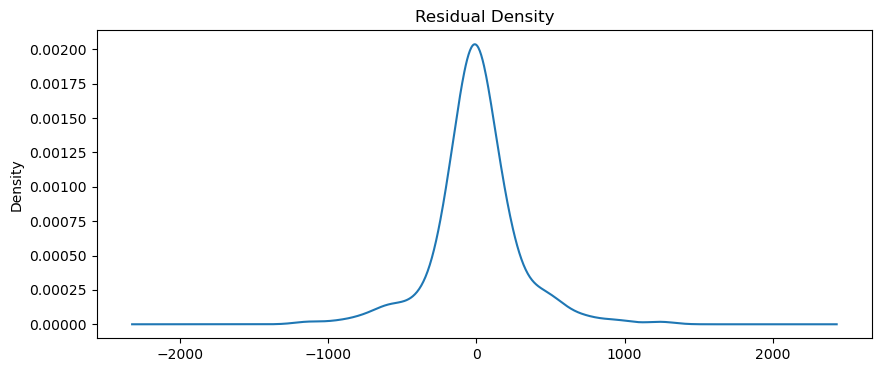

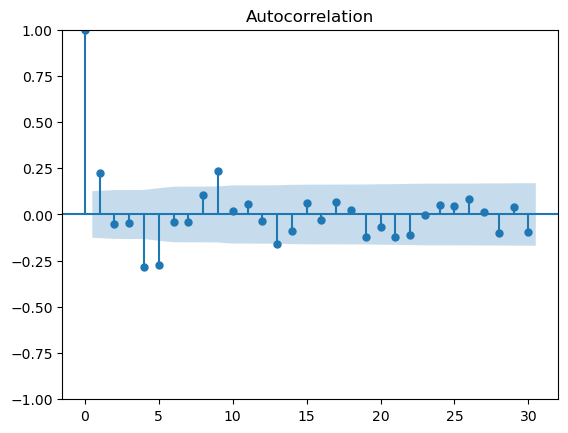

In [26]:
# Plot residuals
residuals = results.resid

plt.figure(figsize=(14, 6))
plt.plot(residuals)
plt.title("Residuals from SARIMA Model")
plt.xlabel("Date")
plt.ylabel("Error")
plt.grid(True)
plt.show()

# Histogram
residuals.plot(kind='kde', title='Residual Density', figsize=(10, 4))
plt.show()

# ACF plot
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(residuals.dropna(), lags=30)
plt.show()


In [27]:
# Load test data
test = pd.read_csv('test.csv', parse_dates=['date'])

# Filter for the same store and product family
test_df = test[(test['store_nbr'] == 1) & (test['family'] == 'BEVERAGES')].copy()

# Set date as index
test_df.set_index('date', inplace=True)
test_df.sort_index(inplace=True)

# Display shape and preview
print(test_df.shape)
test_df.head()


(16, 4)


,id,store_nbr,family,onpromotion
date,,,,
2017-08-16,3000891,1,BEVERAGES,20
2017-08-17,3002673,1,BEVERAGES,17
2017-08-18,3004455,1,BEVERAGES,12
2017-08-19,3006237,1,BEVERAGES,11
2017-08-20,3008019,1,BEVERAGES,10


In [28]:
# Forecast 3 weekly periods into the future
n_periods = 3
forecast = results.get_forecast(steps=n_periods)
forecast_mean = forecast.predicted_mean
conf_int = forecast.conf_int()

# Create forecast dates
forecast_index = pd.date_range(start=weekly_sales.index[-1] + pd.Timedelta(weeks=1), periods=n_periods, freq='W')

# Display results
forecast_df = pd.DataFrame({
    'forecast': forecast_mean,
    'lower_ci': conf_int.iloc[:, 0],
    'upper_ci': conf_int.iloc[:, 1]
}, index=forecast_index)

forecast_df


,forecast,lower_ci,upper_ci
2017-08-27,1963.650612,1394.249152,2533.052072
2017-09-03,2460.843215,1819.188692,3102.497738
2017-09-10,2433.362479,1662.468014,3204.256944


In [29]:
# Repeat each weekly forecast across 7 days
daily_forecast = pd.DataFrame({
    'date': pd.date_range(start='2017-08-21', periods=21, freq='D'),
    'forecast': np.repeat(forecast_df['forecast'].values, 7)
})

# Set index
daily_forecast.set_index('date', inplace=True)

# Preview
daily_forecast.head(10)

,forecast
date,
2017-08-21,1963.650612
2017-08-22,1963.650612
2017-08-23,1963.650612
2017-08-24,1963.650612
2017-08-25,1963.650612
2017-08-26,1963.650612
2017-08-27,1963.650612
2017-08-28,2460.843215
2017-08-29,2460.843215


In [30]:
# Merge forecast with test_df (which already has sales info)
test_compare = test_df.join(daily_forecast, how='left')

# Display result
test_compare[['onpromotion', 'forecast']]

,onpromotion,forecast
date,,
2017-08-16,20,NaN
2017-08-17,17,NaN
2017-08-18,12,NaN
2017-08-19,11,NaN
2017-08-20,10,NaN
2017-08-21,14,1963.650612
2017-08-22,9,1963.650612
2017-08-23,27,1963.650612
2017-08-24,26,1963.650612


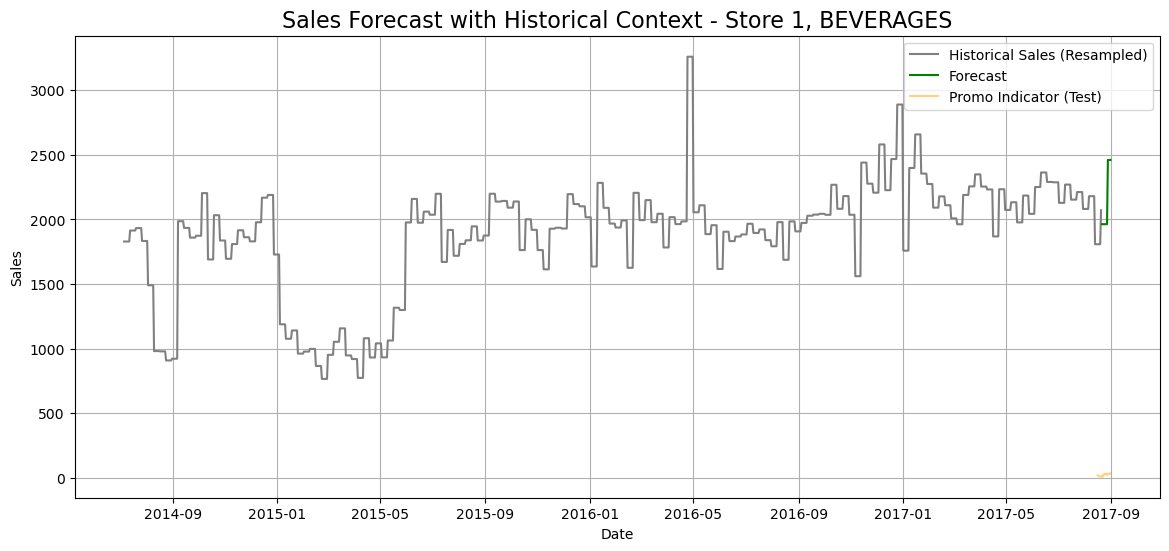

In [ ]:
# Combine recent history and forecast for plotting
plot_start = '2014-07-01' 
recent_history = weekly_sales.loc[plot_start:].resample('D').ffill()  # Forward-fill to daily for visual smoothness

# Plot
plt.figure(figsize=(14, 6))
plt.plot(recent_history.index, recent_history, label='Historical Sales (Resampled)', color='gray')
plt.plot(test_compare.index, test_compare['forecast'], label='Forecast', color='green')
plt.plot(test_compare.index, test_compare['onpromotion'], label='Promo Indicator (Test)', color='orange', alpha=0.5)

plt.title('Sales Forecast with Historical Context - Store 1, BEVERAGES', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()
